Recently, I joined the [Language, Information, and Learning at Yale](https://yale-lily.github.io) lab, led by Professor Dragomir Radev. Although I'm still in what I would consider to be the incipient stages of ML/DL/NLP studies---meaning it will take time for me to be able to actively participate in an contribute to research and publications---I think it will be a great learning experience from which I can glean valuable insight into what research at Yale looks like. 

One of the first projects I was introduced to at the lab is domain-independent table summarization. As the name implies, the goal is to train a model such that it can extract some meaningful insight from the table and produce a human-readable summary. Members are the lab seem to be making great progress in this project, and I'm excited to see where it will go. In the meantime, I decided to write a short post on [BLEU](https://en.wikipedia.org/wiki/BLEU), a metric that I came across while reading some of the survey papers related to this topic. Let's dive into it.

# Introduction

Before going into code and equations, a high-level overview of what BLEU is might be helpful here. BLEU, which stands for Bilingual Evaluation Understudy, is an metric that was introduced to quantitatively evaluate the quality of machine translations. The motivation is clear: as humans, we are able to get an intuitive sense of whether or not a given translation is accurate and of high quality; however, it is difficult to translate this arbitrary linguistic intuition to train NLP models to produce better translations. This is where BLEU comes to the rescue. 

The way BLEU works is simple. Given some candidate translation of a sentence and a group of reference sentences, we use a bag-of-word approach to see how many occurences of BOWs co-occur in both the translation and reference sentences. BOW is a simple yet highly effective way of ensuring that the machine translation contains key phrases or words that reference translations also contain. In other words, BLEU compares candidate translations with human-produced, annotated reference translations and compares how many hits there are in the candidate sentence. The more BOW hits there are, the better the translation. 

Of course, there are many more details that go beyond this. For instance, BLEU is able to account for situations in which meaningless words are repeated throughout the machine translation to simply increase BOW hits. It can also penalize translations that are too short. By combining this BOW precision-based approach with some penalization terms, BLEU provides a robust means of evaluating machine translations. With this high-level overview in mind, let's start implementing BLEU from scratch.

# Preprocessing

First, let's begin by defining some simple preprocessing and helper functions that we will be using throughout this tutorial. The first on the list is `lower_n_split`, which converts a given sentence into lowercase and splits it into tokens, which are, in this case, English words. We could make this more robust using regular expressions to remove punctuations, but for the purposes of this demonstration, let's make this simpler.

In [4]:
lower_n_split = lambda x: x.lower().split()

I decided to use anonymous functions for the sake of simplicity and code readability. Next, let's write a function that creates n-grams from a given sentence. This involves tokenizing the given sentence using `lower_n_split`, then looping through the tokens to create a bag of words. 

In [5]:
def make_ngrams(sentence, n):
    words = lower_n_split(sentence)
    ngrams = []
    for i in range(len(words) - n + 1):
        ngrams.append(" ".join(words[i : i + n]))
    return ngrams

And here is a quick sanity check of what we've done so far.

In [6]:
make_ngrams("This is an example sentence", 2)

['this is', 'is an', 'an example', 'example sentence']

# Motivating BLEU

The BLEU score is based on a familar concept in machine learning: [precision](https://en.wikipedia.org/wiki/Precision_and_recall). Formally, precision is defined as 

$$
\text{Precision} = \frac{tp}{tp + fp}
$$

where $tp$ and $fp$ stand for true and false positives, respectively. 

In the context of machine translations, we can consider positives as roughly corresponding to the notion of hits or matches. In other words, the positives are the bag of word n-grams we can construct from a given candidate translation. True positives are n-grams that appear in both the candidate and some reference translation; false positives are those that only appear in the candidate translation. Let's use this intuition to build a simple precision-based metric.

## Simple Precision

First, we need to create some n-grams from the candidate translation. Then, we iterate through the n-grams to see if they exist in any of the n-grams generated from reference translations. We count the total number of such hits, or true positives, and divide that quantity by the total number of n-grams produced from the candidate translation.

In [7]:
def simple_precision(ca, refs, n):
    ngrams = make_ngrams(ca, n)
    count = 0
    for ngram in ngrams:
        for ref in refs:
            if ngram in make_ngrams(ref, n):
                count += 1
                break
    return count / len(ngrams)

Below are some candidate sentences and reference translations that we will be using as an example throughout this tutorial. 

In [8]:
ca_1 = "It is a guide to action which ensures that the military always obeys the commands of the party"
ca_2 = "It is to insure the troops forever hearing the activity guidebook that party direct"
refs = [
    "It is a guide to action that ensures that the military will forever heed Party commands",
    "It is the guiding principle which guarantees the military forces always being under the command of the Party",
    "It is the practical guide for the army always to heed the directions of the party"
]

Comparing `ca_1` with `ca_2`, it is pretty clear that the former is the better translation. Let's see if the simple precision metric is able to capture this intuition.

In [9]:
print(simple_precision(ca_1, refs, 1))
print(simple_precision(ca_2, refs, 1))

0.9444444444444444
0.5714285714285714


And indeed that seems to be the case!

## Modified Precision

However, the simple precision-based metric has some huge problems. As an extreme example, consider the following `bad_ca` candidate translation.

In [10]:
bad_ca = "It it it it it it it it it it it it it"
print(simple_precision(bad_ca, refs, 1))

1.0


Obviously, `bad_ca` is a horrible translation, but the simple precision metric fails to flag it. This is because precision simply involves checking whether a hit occurs or not: it does not check for repeated bag of words. Hence, the original authors of BLEU introduces modified precision as a solution, which uses clipped counts. The gist of it is that, if some n-gram is repeated many times, we clip its count through the following formula:

$$
\text{Count} = \text{min}(m_w, m_\text{max})
$$

Here, $\text{Count}$ refers to the number of hits we assign to a certain n-gram. We sum this value over all *distinct* n-grams in the candidate sentence. Note that the distinction requirement effectively weeds out repetitive translations such as `bad_ca` we looked at earlier. 

$m_w$ refers to the number of occurrences of a n-gram in the candidate sentence. For example, in `bad_ca`, the unigram `"it"` appears 13 times, and so $m_w = 13$. This value, however, is clipped by $m_\text{max}$, which is the maximum number of occurrence of that n-gram in any one of the reference sentences. In other words, for each reference, we count the number of occurrence of that n-gram and take the maximum value among them. 

This can seem very confusing, but hopefully it's clearer once you read the code. Here is my implementation using `collections.Counter`. 

In [11]:
from collections import Counter

def modified_precision(ca, refs, n):
    ngrams = make_ngrams(ca, n)
    ngram_counts = Counter(ngrams)
    total_count = 0
    for ngram in set(ngrams):
        max_count = 0
        for ref in refs:
            max_count = max(max_count, Counter(make_ngrams(ref, n)).get(ngram, 0))
        total_count += min(max_count, ngram_counts[ngram])
    return total_count / len(ngrams)

Notice that we use a `set` in order to remove redundancies. `max_count` corresponds to $m_\text{max}$; `ngram_counts[ngram]` corresponds to $m_w$.

Using this modified metric, we can see that the `bad_ca` is now penalized quite a lot through the clipping mechanism.

In [12]:
print(modified_precision(bad_ca, refs, 1))

0.07692307692307693


## N-grams

But there are still problems that modified precision doesn't take into account. Consider the following example translation.

In [13]:
ca_3 = "the that military a is It guide ensures which to commands the of action obeys always party the"
print(modified_precision(ca_3, refs, 1))

0.9444444444444444


To us, it's pretty obvious that `ca_3` is a bad translation. Although some of the key words might be there, the order in which they are arranged violates English syntax. This is the limitation of using unigrams for precision analysis. To make sure that sentences are coherent and read fluently, we now have to introduce the notion of n-grams, where $n$ is larger than 1. This way, we can preserve some of the sequential encoding in reference sentences and make better comparison. 

The fact that unigrams are a poor way of evaluating translations becomes immediately clear once we plot the $n$ in n-grams against modified precision. 

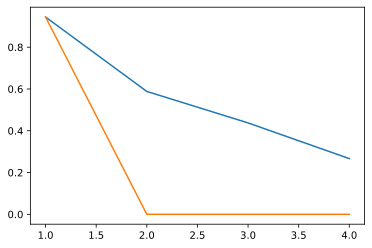

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

n = range(1, 5)
y_1 = [modified_precision(ca_1, refs, n_) for n_ in n]
y_2 = [modified_precision(ca_3, refs, n_) for n_ in n]

plt.plot(n, y_1)
plt.plot(n, y_2)
plt.show()

As you can see, precision score decreases as $n$ gets higher. This makes sense: a larger $n$ simply means that the window of comparison is larger. Unless whole phrases co-occur in the translation and reference sentences---which is highly unlikely---precision will be low. People have generally found that a suitable $n$ value lies somewhere around 1 and 4. As we will see later, packages like `nltk` use what is known as cumulative 4-gram BLEU score, or BLEU-4. 

The good news is that our current implementation is already able to account for different $n$ values. This is because we wrote a handy little function, `make_ngrams`. By passing in different values to `n`, we can deal with different n-grams.

## Brevity Penalty

Now we're almost done. The last example to consider is the following translation:

In [15]:
bad_short_ca = "it is"

This is obviously a bad translation. However, due to the way modified precision is currently being calculated, this sentence will likely earn a high score. To prevent this from happening, we need to apply what is known as brevity penalty. As the name implies, this penalizes short candidate translations, thus ensuring that only sufficiently long machine translations are ascribed a high score. 

In [16]:
import numpy as np

def brevity_penalty(ca, refs):
    ca_len = len(ca)
    if ca_len == 0:
        return 0
    cleaned_refs = (lower_n_split(ref) for ref in refs)
    ref_lens = (len(ref) for ref in cleaned_refs)
    closest_ref_len = min(ref_lens, key=lambda ref_len: abs(ca_len - ref_len))
    return 1 if ca_len > closest_ref_len else np.exp(1 - closest_ref_len / ca_len)

Although this might seem confusing, the underlying mechanism is quite simple. The goal is to find the length of the reference sentence whose length is closest to that of the candidate translation in question. If the length of that reference sentence is larger than the candidate sentence, we apply some penalty; if the candidate sentence is longer, than we do not apply any penalization. The specific formula for penalization looks as follows:

$$
\text{BP} = 
\begin{cases}
1 && l_\text{ca} > l_\text{ref} \\ 
\text{exp} \left( 1 - \frac{l_\text{ref}}{l_\text{ca}} \right) && l_\text{ca} \leq l_\text{ref} \\ 
\end{cases}
$$

The brevity penalty term is multiplied to the n-gram modified precision. Therefore, a value of 1 means that no penalization is applied. 

Let's perform a quick sanity check to see whether the brevity penalty function works as expected.

In [17]:
brevity_penalty(bad_short_ca, refs)

0.11080315836233387

In [18]:
brevity_penalty(ca_1, refs)

1

## BLEU

Finally, it's time to put all the pieces together. The formula for BLEU can be written as follows:

$$
\text{BLEU} = \text{BP} \cdot \text{exp} \left( \sum_{n=1}^N w_n \log{p_n} \right)
$$

First, some notation clarifications. $n$ specifies the size of the bag of word, or the n-gram. $w_k$ denotes the weight we will ascribe to the modified precision---$p_k$---produced under that $k$-gram configuration. In other words, we calculate the weighted average of log precision, exponentiate that sum, and apply some brevity penalty. Although this can sound like a lot, really it's just putting all the pieces we have discussed so far together. Let's take a look at the code implementation.

In [19]:
def bleu(ca, refs, weights, n_start, n_end):
    assert n_end >= n_start > 0
    bp = brevity_penalty(ca, refs)
    p_n = [modified_precision(ca, refs, n) for n in range(n_start, n_end + 1)]
    return bp * np.exp(sum(w * np.log(p) for w, p in zip(weights, p_n)))

The weighting happens in the `zip` part within the generator expression within the `return` statement. In this case, we apply weighting across $n$ that goes from `n_start` to `n_end`. 

Now we're done! Let's test out our final implementation with `ca_1` for $n$ from 1 to 4, all weighted equally.

In [20]:
bleu(ca_1, refs, [0.25, 0.25, 0.25, 0.25], 1, 4)

0.5045666840058485

The `nltk` package offers functions for BLEU calculation by default. For convenience purposes, let's create a wrapper functions. This wrapping isn't really necessary, but it abstracts out many of the preprocessing steps, such as applying `lower_n_split`. This is because the `nltk` BLEU calculation function expects tokenized input, whereas `ca_1` and `refs` are untokenized sentences.

In [21]:
import nltk.translate.bleu_score as bleu

def nltk_bleu(ca, refs):
    return bleu.sentence_bleu(list(map(lambda ref: lower_n_split(ref), refs)), lower_n_split(ca))

And we see that the result matches that derived from our own implementation!

In [22]:
nltk_bleu(ca_1, refs)

0.5045666840058485

# Conclusion

In this post, we took a look at BLEU, a very common way of evaluating the fluency of machine translations. Studying the implementation of this metric was a meaningful and interesting process, not only because BLEU itself is widely used, but also because the motivation and intuition behind its construction was easily understandable and came very naturally to me. Each component of BLEU addresses some problem with simpler metrics, such as precision or modified precision. It also takes into account things like abnormally short or repetitive translations. 

One area of interest for me these days is seq2seq models. Although RNN models have largely given way to transformers, I still think it's a very interesting architecture worth diving into. I've also recently ran into a combined LSTM-CNN approach for processing series data. I might write about these topics in a future post. 

I hope you've enjoyed reading this post. Catch you up later!